# Context

Online travel agencies (OTAs) and hotel revenue-management systems use **dynamic pricing** that reacts to lead-time, seasonality, room type, cancellations, demand, and even the day-of-week. Unlike fixed-rate package holidays, nightly prices can spike for peak weekends, local events, or when inventory (room availability) is tight. How sensitive are guests to those price swings? This project explores **price elasticity of demand** for hotel rooms, showing when higher nightly rates dampen bookings, when they’re absorbed without fuss, and what that means for revenue.

Because the raw file does not contain an explicit *“demand”* field, for simplicity sake, **I define demand** as the ***daily count of non-cancelled bookings***. That derived metric will serve as the dependent variable throughout the analysis.   

> You can find the dataset [here](https://www.kaggle.com/datasets/ahmedwaelnasef/hotel-booking).   
> View full analysis on [Kaggle](...).

_**In this analysis, I will be performing the following:**_

---

### Objectives

- **Most in demand room options**:  
  Identify the hotel’s most popular room types by non-cancelled booking volume.

- **Estimate price elasticity of demand**:  
  Analyse how price changes affect booking volume for these rooms to determine if demand is *elastic or inelastic*.

- **Forecast future demand**:  
  Use time-series models (Prophet) to predict booking trends and occupancy for top room types.

- **Optimise pricing strategy**:  
  Find optimal price points that maximise revenue while maintaining stable demand over the next 7 days.

- **Business Analytics**:  
  Build an interactive dashboard to simulate how price changes impact demand over user-selected timeframes.


---

**NOTE**: This project is part of my weekly series in efforts to **demystify applied statistical techniques through real-world, project-driven examples**, making concepts like propensity modelling, causal inference, and evaluation metrics more accessible to practitioners of all backgrounds.


### Let's connect! --> [LinkedIn](https://www.linkedin.com/in/einstein-ebereonwu/) | [X](https://x.com/einsteinmuna) | [GitHub.](https://github.com/munas-git)

# Importing Important Libraries

In [1]:
# data wrangling
import calendar
import pandas as pd
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# numerical analysis
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

# wholistic outlier/anomaly detection
from sklearn.ensemble import IsolationForest

# data vis
import seaborn as sns
import matplotlib.pyplot as plt

# model training
from sklearn.neighbors import KNeighborsRegressor

# model evaluation
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, median_absolute_error, r2_score,
    explained_variance_score, max_error, mean_squared_log_error, mean_poisson_deviance, mean_gamma_deviance)

# hyper-params optimisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')

All done...


In [2]:
df = pd.read_csv('/kaggle/input/hotel-booking/Hotel.csv')
df.head()

,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,market_segment,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


# Initial EDA, Feature Engineering & Table Merging.

## Initial EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              36275 non-null  object 
 1   n_adults                        36275 non-null  int64  
 2   n_children                      36275 non-null  int64  
 3   weekend_nights                  36275 non-null  int64  
 4   week_nights                     36275 non-null  int64  
 5   meal_plan                       36275 non-null  object 
 6   car_parking_space               36275 non-null  int64  
 7   room_type                       36275 non-null  object 
 8   lead_time                       36275 non-null  int64  
 9   year                            36275 non-null  int64  
 10  month                           36275 non-null  int64  
 11  date                            36275 non-null  int64  
 12  market_segment                  

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_adults,36275.0,1.844962,0.518715,0.0,2.0,2.00,2.0,4.0
n_children,36275.0,0.105279,0.402648,0.0,0.0,0.00,0.0,10.0
weekend_nights,36275.0,0.810724,0.870644,0.0,0.0,1.00,2.0,7.0
week_nights,36275.0,2.204300,1.410905,0.0,1.0,2.00,3.0,17.0
car_parking_space,36275.0,0.030986,0.173281,0.0,0.0,0.00,0.0,1.0
lead_time,36275.0,85.232557,85.930817,0.0,17.0,57.00,126.0,443.0
year,36275.0,2017.820427,0.383836,2017.0,2018.0,2018.00,2018.0,2018.0
month,36275.0,7.423653,3.069894,1.0,5.0,8.00,10.0,12.0
date,36275.0,15.596995,8.740447,1.0,8.0,16.00,23.0,31.0
repeated_guest,36275.0,0.025637,0.158053,0.0,0.0,0.00,0.0,1.0


**Observation**   

No missing data, that's good.   

However, there are outliers... Some quite extreme like `n_children` and `week_nights`, and some others which are not so extreme. There is also no repeated data. For further understanding of the potential outliers, I will be taking a closer look using box plots.   

**Note:**  
I identified potential outliers from the describe table statistics by examining the ***mean, standard deviation, and maximum values***. *With the assumption that the data follows an approximately normal distribution*, I flagged observations as outliers if they fall beyond 3 standard deviations from the mean (99.7th percentile).

## Basic Outlier detection

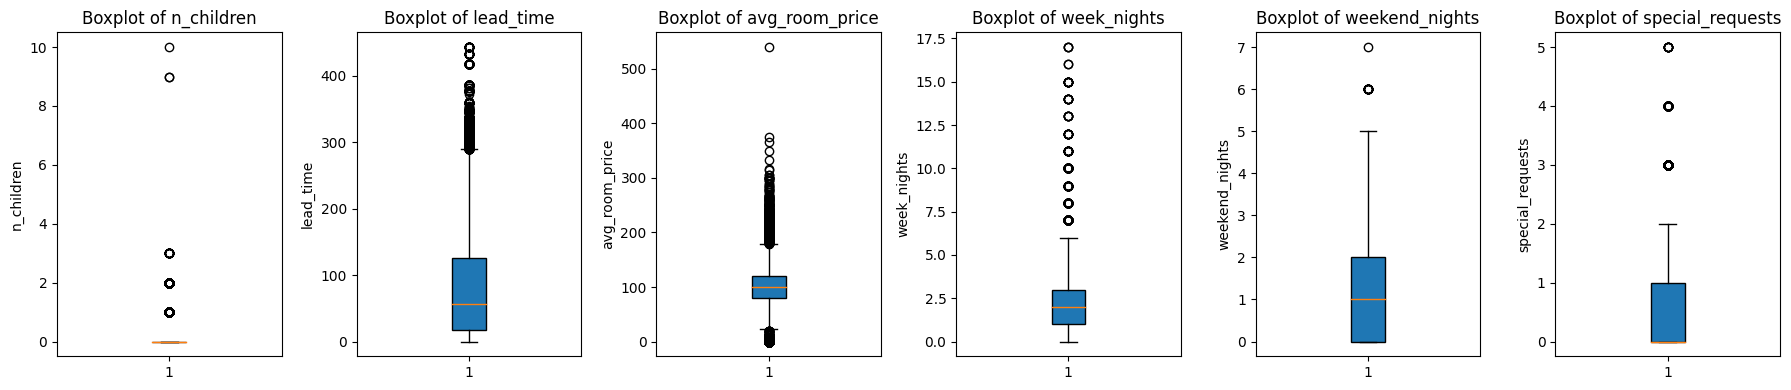

In [5]:
cols_to_plot = [
    'n_children', 'lead_time', 'avg_room_price',
    'week_nights', 'weekend_nights', 'special_requests']

plt.figure(figsize = (18, 4))

for i, col in enumerate(cols_to_plot, start = 1):
    plt.subplot(1, 6, i)
    plt.boxplot(df[col], patch_artist = True)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [6]:
print(f'Different room types: {sorted(df.room_type.unique())}')
df[df['n_children'] > 8].sort_values(by = 'n_children', ascending = False)

Different room types: ['Room_Type 1', 'Room_Type 2', 'Room_Type 3', 'Room_Type 4', 'Room_Type 5', 'Room_Type 6', 'Room_Type 7']


,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,market_segment,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status
6338,INN06339,2,10,0,2,Meal Plan 1,0,Room_Type 4,37,2018,1,12,Online,0,0,0,84.45,1,Not_Canceled
10041,INN10042,1,9,2,1,Meal Plan 1,0,Room_Type 1,11,2017,10,11,Corporate,0,0,0,95.00,0,Not_Canceled
10061,INN10062,2,9,2,5,Meal Plan 1,0,Room_Type 2,8,2017,8,13,Online,0,0,0,76.50,1,Canceled


In [7]:
original_avg_room_price_1p8_percentile = df['avg_room_price'].quantile(0.018)
print(f'Unclean dataset "avg_room_price" 1.8th percentile: {original_avg_room_price_1p8_percentile:.2f}')

Unclean dataset "avg_room_price" 1.8th percentile: 36.25


**Observations**

- **`n_children`**: Based on the boxplot, values above **8 children** clearly stand out as potential outliers. However, upon closer inspection, I noticed that:
  - The **highest value** (10 children) occurred in **Room_Type 4**, which I assume is one of the **larger room types**.
  - The booking was made around **New Year**, a time known for **gatherings or events**.
  - The guest also included a **special request**, suggesting this may have been a **group event or party**, rather than a single family booking.

**Note**  
Since the outliers identified here is quite plausible, simply dropping all **univariate outliers** wouldn't be wise, and I don't want to have to individually inspect `lead_time, average_room_price,` and the rest in the same manner, only to observe similar plausible patterns. There are very obvious issues with the `average room prices`, as quite a number of them are 0 or near it. I will handle that shortly.   

For a more robust approach to outlier identification, I'll be working with **Isolation Forests**. This technique helps identify **observation-level outliers** rather than just feature-level anomalies, a more **holistic and scalable** approach, especially useful for **production settings**.

## Initial Feature Engineering + Advanced Outlier Detection & Handling

In [8]:
# ordinal category mappings
meal_plan_mapping = {'Not Selected': -1, 'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3': 3}
room_type_mapping = {'Room_Type 1': 1, 'Room_Type 2': 2, 'Room_Type 3': 3, 'Room_Type 4': 4, 
                     'Room_Type 5': 5, 'Room_Type 6': 6, 'Room_Type 7': 7}

df['meal_plan'] = df['meal_plan'].map(meal_plan_mapping)
df['room_type'] = df['room_type'].map(room_type_mapping)


# label encoding... binary
status_le = LabelEncoder()
df['status'] = status_le.fit_transform(df['status'])

# one-hot encode nominal category
ohe = OneHotEncoder(sparse_output = False, dtype = int, drop = 'first')
market_segment_encoded = ohe.fit_transform(df[['market_segment']])

feature_names = [f"market_segment_{cat}" for cat in ohe.categories_[0][1:]] # excluding first
for i, col_name in enumerate(feature_names):
    df[col_name] = market_segment_encoded[:, i]

df = df.drop('market_segment', axis = 1)

In [9]:
df.head()

,ID,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,...,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online
0,INN00001,2,0,1,2,1,0,1,224,2017,...,0,0,0,65.00,0,1,0,0,1,0
1,INN00002,2,0,2,3,-1,0,1,5,2018,...,0,0,0,106.68,1,1,0,0,0,1
2,INN00003,1,0,2,1,1,0,1,1,2018,...,0,0,0,60.00,0,0,0,0,0,1
3,INN00004,2,0,0,2,1,0,1,211,2018,...,0,0,0,100.00,0,0,0,0,0,1
4,INN00005,2,0,1,1,-1,0,1,48,2018,...,0,0,0,94.50,0,0,0,0,0,1


In [10]:
X = df.drop(['ID'], axis = 1)

iso = IsolationForest(
    n_estimators = 300,
    contamination = 0.001,
    random_state = 42)

iso.fit(X)

df["iso_flag"]  = iso.predict(X)
df["iso_score"] = iso.decision_function(X)

outliers = (
    df[df["iso_flag"] == -1]
    .sort_values("iso_score"))

# display(outliers)

In [11]:
print(f'Outliers percentage: {round(len(df[df["iso_flag"] == -1]) / len(df) * 100, 4)}%')
print(f'Number of identified outliers: {len(df[df["iso_flag"] == -1])}')
print(f'Number of borderline observations (confusing to decice by model): {len(df[df["iso_score"] == 0])}')

Outliers percentage: 0.102%
Number of identified outliers: 37
Number of borderline observations (confusing to decice by model): 0


In [12]:
# Quick sanity check... is the January case of 10 kids and room type 4 flagged?
'INN06339' in outliers['ID'].values

False

### Further dive into what exactly makes them outliers

In [13]:
# In this cell, I use each tree to extract the decision path for each sample,
# then track which features were used to isolate each outlier.
# Features that appear earlier in the path get more weight.
# In the end, I quantify how much each feature contributed to the isolation,
# helping explain which feature combinations result in rare/anomalous observations.


# ====================== VERY IMPORTANT REUSABLE FUNCTION FOR FUTURE PROJECTS (Outlier Flag Explainability) ======================
def get_contributions(model, X, row_idx, feature_names, threshold = 0.05):
    x = X[row_idx].reshape(1, -1)
    contrib = np.zeros(X.shape[1])

    for tree in model.estimators_:
        node_ids = tree.decision_path(x).indices
        for depth, node_id in enumerate(node_ids, start = 1):
            feat = tree.tree_.feature[node_id]
            if feat >= 0:
                contrib[feat] += 1 / depth # higher weight to quicker splits... inverse or smaller numbers are higher
            else:
                break
                
    contrib /= contrib.sum()
    return pd.Series(contrib, index = feature_names, name = row_idx)
# ====================== VERY IMPORTANT REUSABLE FUNCTION FOR FUTURE PROJECTS (Outlier Flag Explainability) ======================



# outliers only
outlier_idx = df[df['iso_flag'] == -1].sort_values('iso_score').index
feature_names = X.columns

contrib_df = pd.DataFrame([
    get_contributions(iso, X.values, i, feature_names)
    for i in outlier_idx], index = outlier_idx)

value_df = X.loc[outlier_idx].copy()
value_df['iso_score'] = df.loc[outlier_idx, 'iso_score']
gmap = contrib_df.where(contrib_df > 0.05, 0.0)
gmap["iso_score"] = 0.0

styled = (value_df.style.background_gradient(cmap = 'Reds', axis = None, gmap = gmap).format('{:.4f}'))


print('NOTE: The heavier the shade of red, the more significant the feature was in determining the observation is an outlier\n')
display(styled) # .... This only works in notebook environments, so I suggest viewing the Kaggle notebook.

NOTE: The heavier the shade of red, the more significant the feature was in determining the observation is an outlier



,n_adults,n_children,weekend_nights,week_nights,meal_plan,car_parking_space,room_type,lead_time,year,month,date,repeated_guest,previous_cancellations,previous_bookings_not_canceled,avg_room_price,special_requests,status,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online,iso_score
21880,1.0000,0.0000,2.0000,1.0000,1.0000,1.0000,1.0000,11.0000,2018.0000,12.0000,17.0000,1.0000,5.0000,57.0000,67.0000,2.0000,1.0000,0.0000,1.0000,0.0000,0.0000,-0.0385
23366,4.0000,0.0000,0.0000,1.0000,1.0000,1.0000,7.0000,4.0000,2018.0000,5.0000,13.0000,1.0000,0.0000,2.0000,0.0000,4.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0315
8622,1.0000,0.0000,1.0000,0.0000,1.0000,1.0000,1.0000,5.0000,2018.0000,12.0000,5.0000,1.0000,2.0000,8.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0290
33393,1.0000,0.0000,0.0000,3.0000,1.0000,1.0000,4.0000,0.0000,2018.0000,1.0000,5.0000,1.0000,0.0000,12.0000,0.0000,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0274
27665,2.0000,0.0000,1.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,12.0000,19.0000,1.0000,4.0000,20.0000,0.0000,2.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0270
3050,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,5.0000,4.0000,1.0000,4.0000,15.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0246
18794,1.0000,0.0000,0.0000,2.0000,1.0000,1.0000,1.0000,7.0000,2018.0000,12.0000,14.0000,1.0000,5.0000,56.0000,67.0000,2.0000,1.0000,0.0000,1.0000,0.0000,0.0000,-0.0246
36080,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,3.0000,21.0000,1.0000,3.0000,15.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0228
19292,3.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,71.0000,2018.0000,10.0000,15.0000,1.0000,0.0000,32.0000,0.0000,4.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0224
35983,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,7.0000,0.0000,2018.0000,6.0000,7.0000,1.0000,4.0000,17.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,-0.0217


**Observation**

This technique was not only effective in identifying records with an `avg_room_price` of **0.0**, but it also identified other **rare booking combinations**. For example, bookings made for **1 adult to span across 2 weekend nights and 1 week night, with 2 special requests in December** is quite uncommon.... Something more common based on my own intuition would be 2 adults and at least 1 child, for that timwe of the year. Anyways, `I will be proceeding with a 2-step approach`....   

**1.** ***Dropping Outliers***   
I will be dropping every single identified outlier, since there are only 37 of them and not a significant loss compared to the amount of data I have. I will also be excluding every observation with room price above 400 after that, in order to avoid unnecessary skewing.

**2.** ***Imputing Wrong Prices***

After removing the outliers, I will be **replacing the `avg_room_price` values of 0** with predictions from a **K-Nearest Neighbors (KNN) regressor**, using booking-specific patterns across all features in order to balance **precision** with **robustness** unlike a mean fill which may have lost some finer details.

In [14]:
df_clean = df.drop(outliers.index)
print(f'Number of cleaned observations with room price above 400 --> {len(df_clean[df_clean["avg_room_price"] >= 400])}')

df_clean = df_clean[df_clean['avg_room_price'] < 400]

Number of cleaned observations with room price above 400 --> 1


In [15]:
# some clean up

cleanup_cols = ['ID', 'iso_flag', 'iso_score']
df_clean.drop(cleanup_cols, axis = 1, inplace = True)

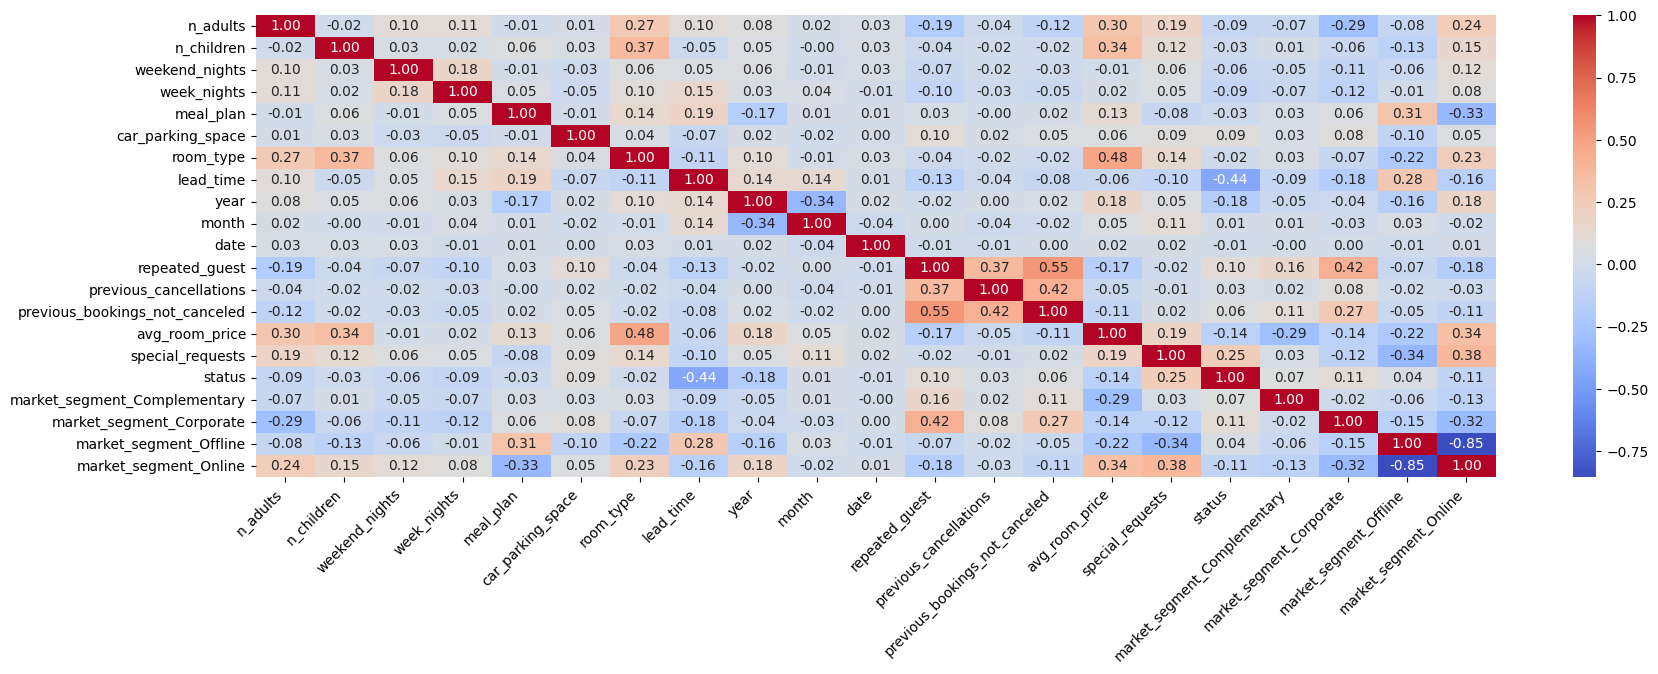

In [16]:
corr = df_clean.corr()

plt.figure(figsize = (20, 6))
sns.heatmap(corr, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.xticks(rotation = 45, ha = 'right');

**Observation**

As expected, the one-hot-encoded variables are highly correlated, and will be ignored. Asides those, the `repeated_guest` and `previous_bookings_not_canceled` are highly correlated with a correlation score of ***0.55***. I will be dropping `repeated_guest` because any `previous_bookings_not_canceled` *> 1* automatically equates to a repeat guest and the number of prevoous bookings not cancelled carries more information than just a boolean flag.

In [17]:
# some extra clean up

cleanup_cols = ['repeated_guest']
df_clean.drop(cleanup_cols, axis = 1, inplace = True)

print(f'Number of cleaned observations with unlikely average price: {len(df_clean[df_clean["avg_room_price"] <= original_avg_room_price_1p8_percentile])}')

Number of cleaned observations with unlikely average price: 629


## KNN Data Imputation

In [18]:
train_df = df_clean[df_clean['avg_room_price'] > original_avg_room_price_1p8_percentile].copy()
pred_df  = df_clean[df_clean['avg_room_price'] <= original_avg_room_price_1p8_percentile].copy()

feature_cols = [c for c in df_clean.columns if c != 'avg_room_price']
X_train = train_df[feature_cols]
y_train = train_df['avg_room_price']
X_pred  = pred_df[feature_cols]

one_hot_cols = [c for c in feature_cols if c.startswith('market_segment_')]
ordinal_cols = [c for c in feature_cols if c not in one_hot_cols]

# ordinal feature scaling
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_pred_scaled = X_pred.copy()

X_train_scaled[ordinal_cols] = scaler.fit_transform(X_train[ordinal_cols])
X_pred_scaled[ordinal_cols] = scaler.transform(X_pred[ordinal_cols])

# Grid search for best k
param_grid = {'n_neighbors': [3, 5, 6, 7, 9, 11]}
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

gs = GridSearchCV(KNeighborsRegressor(metric = 'euclidean'),
                  param_grid, cv=cv,
                  scoring = 'neg_mean_squared_error', n_jobs = -1)
gs.fit(X_train_scaled, y_train)

print(f'Best k: {gs.best_params_["n_neighbors"]}  (CV RMSE ~= {(-gs.best_score_) ** 0.5:0.1f})')

# filling outlier prices.
best_knn = gs.best_estimator_
pred_prices = best_knn.predict(X_pred_scaled)
df_clean.loc[df_clean['avg_room_price'] <= original_avg_room_price_1p8_percentile, 'avg_room_price'] = pred_prices

df_clean['avg_room_price'].describe()

Best k: 5  (CV RMSE ~= 18.1)


count    36237.000000
mean       105.238873
std         32.436010
min         36.380000
25%         81.000000
50%        100.000000
75%        121.000000
max        375.500000
Name: avg_room_price, dtype: float64

**Observation**

Price descriptive stats look wayyy better than before... Time for further analysis, engineering demand feature, and moving on to price elasticity of demand modelling, demand forcasting and price optimisation.

# Advanced EDA

In [19]:
invalid_dates_info = []

for idx, row in df_clean.iterrows():
    try:
        year, month, day = int(row['year']), int(row['month']), int(row['date'])
        pd.to_datetime(f"{year}-{month:02d}-{day:02d}")
    except Exception as e:
        invalid_dates_info.append({
            'index': idx,
            'year': year,
            'month': month, 
            'day': day,
            'date_string': f"{year}-{month:02d}-{day:02d}",
            'error': str(e)})

print(f"Found {len(invalid_dates_info)} invalid dates:")
print("-" * 60)

print(f'Number of invalid date data recorder: {len(invalid_dates_info)}')
for item in invalid_dates_info[:5]:
    print(f"Index {item['index']}: {item['date_string']} - {item['error']}")

Found 37 invalid dates:
------------------------------------------------------------
Number of invalid date data recorder: 37
Index 2626: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0
Index 3677: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0
Index 5600: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0
Index 6343: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0
Index 7648: 2018-02-29 - day is out of range for month: 2018-02-29, at position 0


In [20]:
df_clean['booking_date'] = pd.to_datetime(
    df_clean['year'].astype(str) + '-' + 
    df_clean['month'].astype(str) + '-' + 
    df_clean['date'].astype(str),
    errors = 'coerce')

print(f'Number of bookings on "2018-02-28": {len(df_clean[df_clean["booking_date"] == "2018-02-28"])}')
print(f'Number of bookings on "2018-03-01": {len(df_clean[df_clean["booking_date"] == "2018-03-01"])}\n')
print(f'\nSuccessful/Valid date conversions: {df_clean["booking_date"].notna().sum()}')

Number of bookings on "2018-02-28": 165
Number of bookings on "2018-03-01": 59


Successful/Valid date conversions: 36200


**Observation**

Turns out some records were **wrongly recorded as 29th of February 2018**, even though that year was **not a leap year**... 

Honestly, I **don't want to be too smart** and move the data to either day before/after since I **don't have records for other significant years to observe**, so I will be **excluding all that phantom data entirely** 

**Oh well...**

## Overall Daily Demand

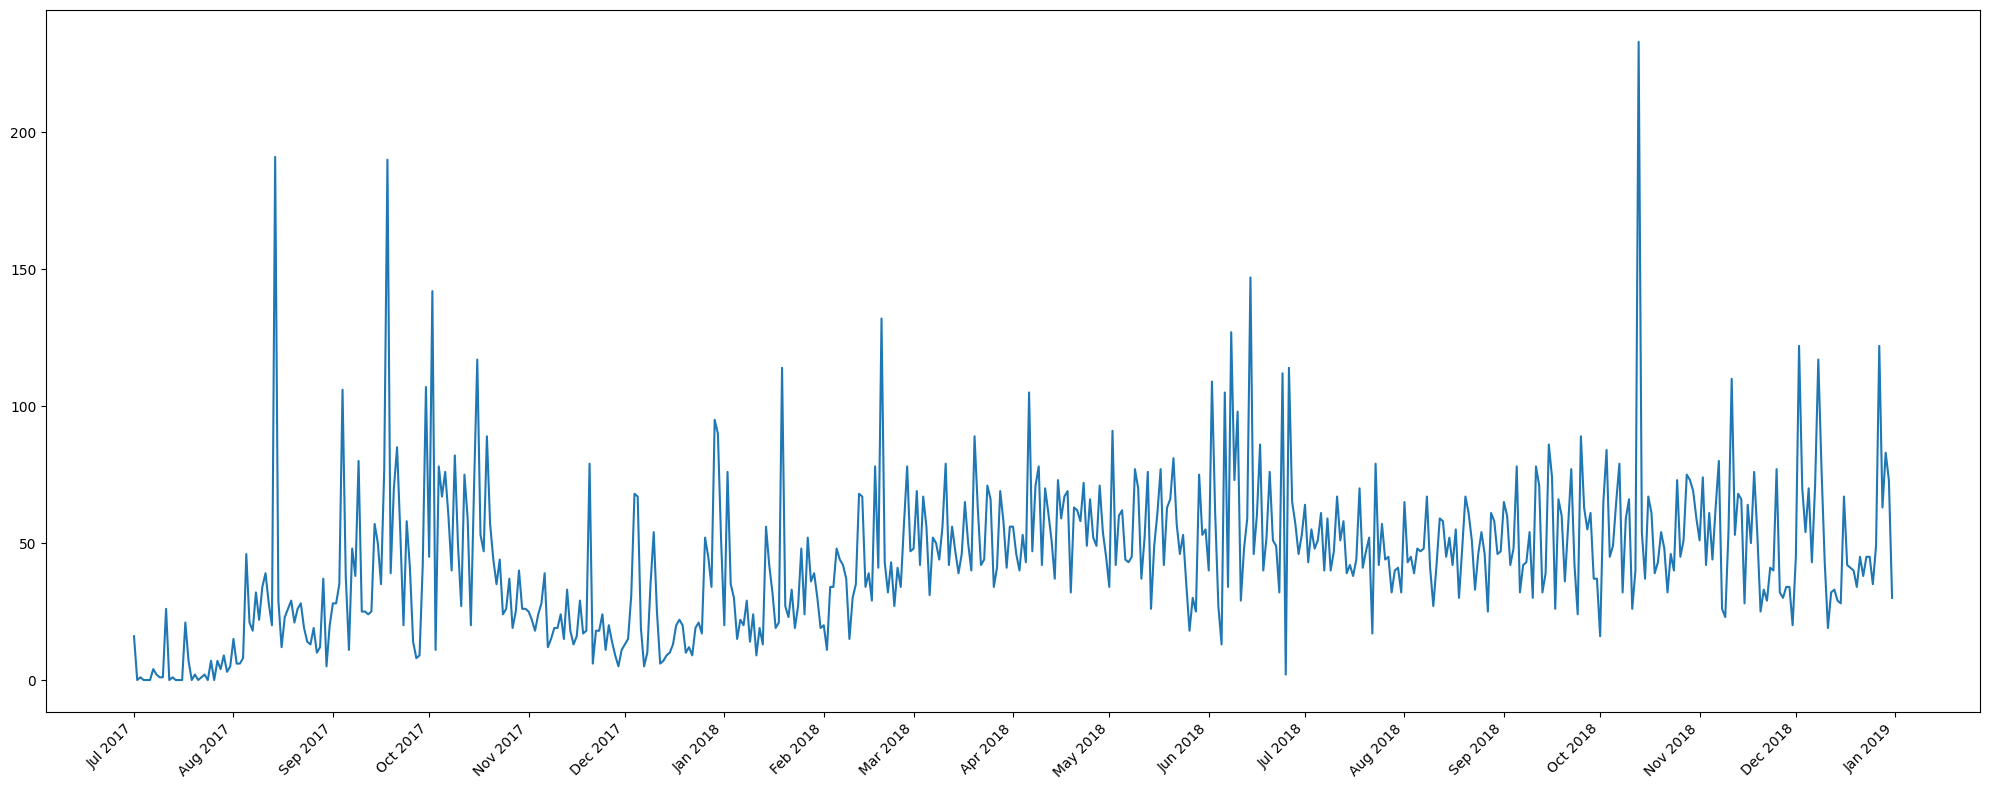

In [21]:
daily_demand_df = (
    df_clean.groupby('booking_date')['status']
    .sum().reset_index(name = 'demand'))


plt.figure(figsize = (20, 8))
plt.plot(daily_demand_df['booking_date'], daily_demand_df['demand'])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation = 45, ha = 'right')

plt.tight_layout()
plt.show()

**Observation**

There are **clear seasonal trends** in the data, with **notable peaks consistently occurring between August and October** in both years. This pattern suggests **increased bookings during late summer and early autumn**.

Several **anomalies stand out**, particularly in **August and September of 2017**, and again in **November 2018**. These may correspond to **special events, holidays, or conferences** that caused unusual spikes in activity.

In addition, there are **stable but significant peaks** around **early and late December**, extending into **January**, likely reflecting **holiday season travel**. Other prominent peaks appear in **March, June, and July of 2018**, indicating **secondary seasonal demand** or possibly **regional events** influencing booking behavior during those months.

## Daily Demand by Room Type

In [22]:
daily_room_demand_df = (
    df_clean.groupby(['booking_date', 'room_type'])['status']
    .sum().reset_index(name = 'demand'))

daily_room_demand_df.room_type.value_counts()

room_type
1    549
4    473
6    352
2    240
5    151
7    115
3      6
Name: count, dtype: int64

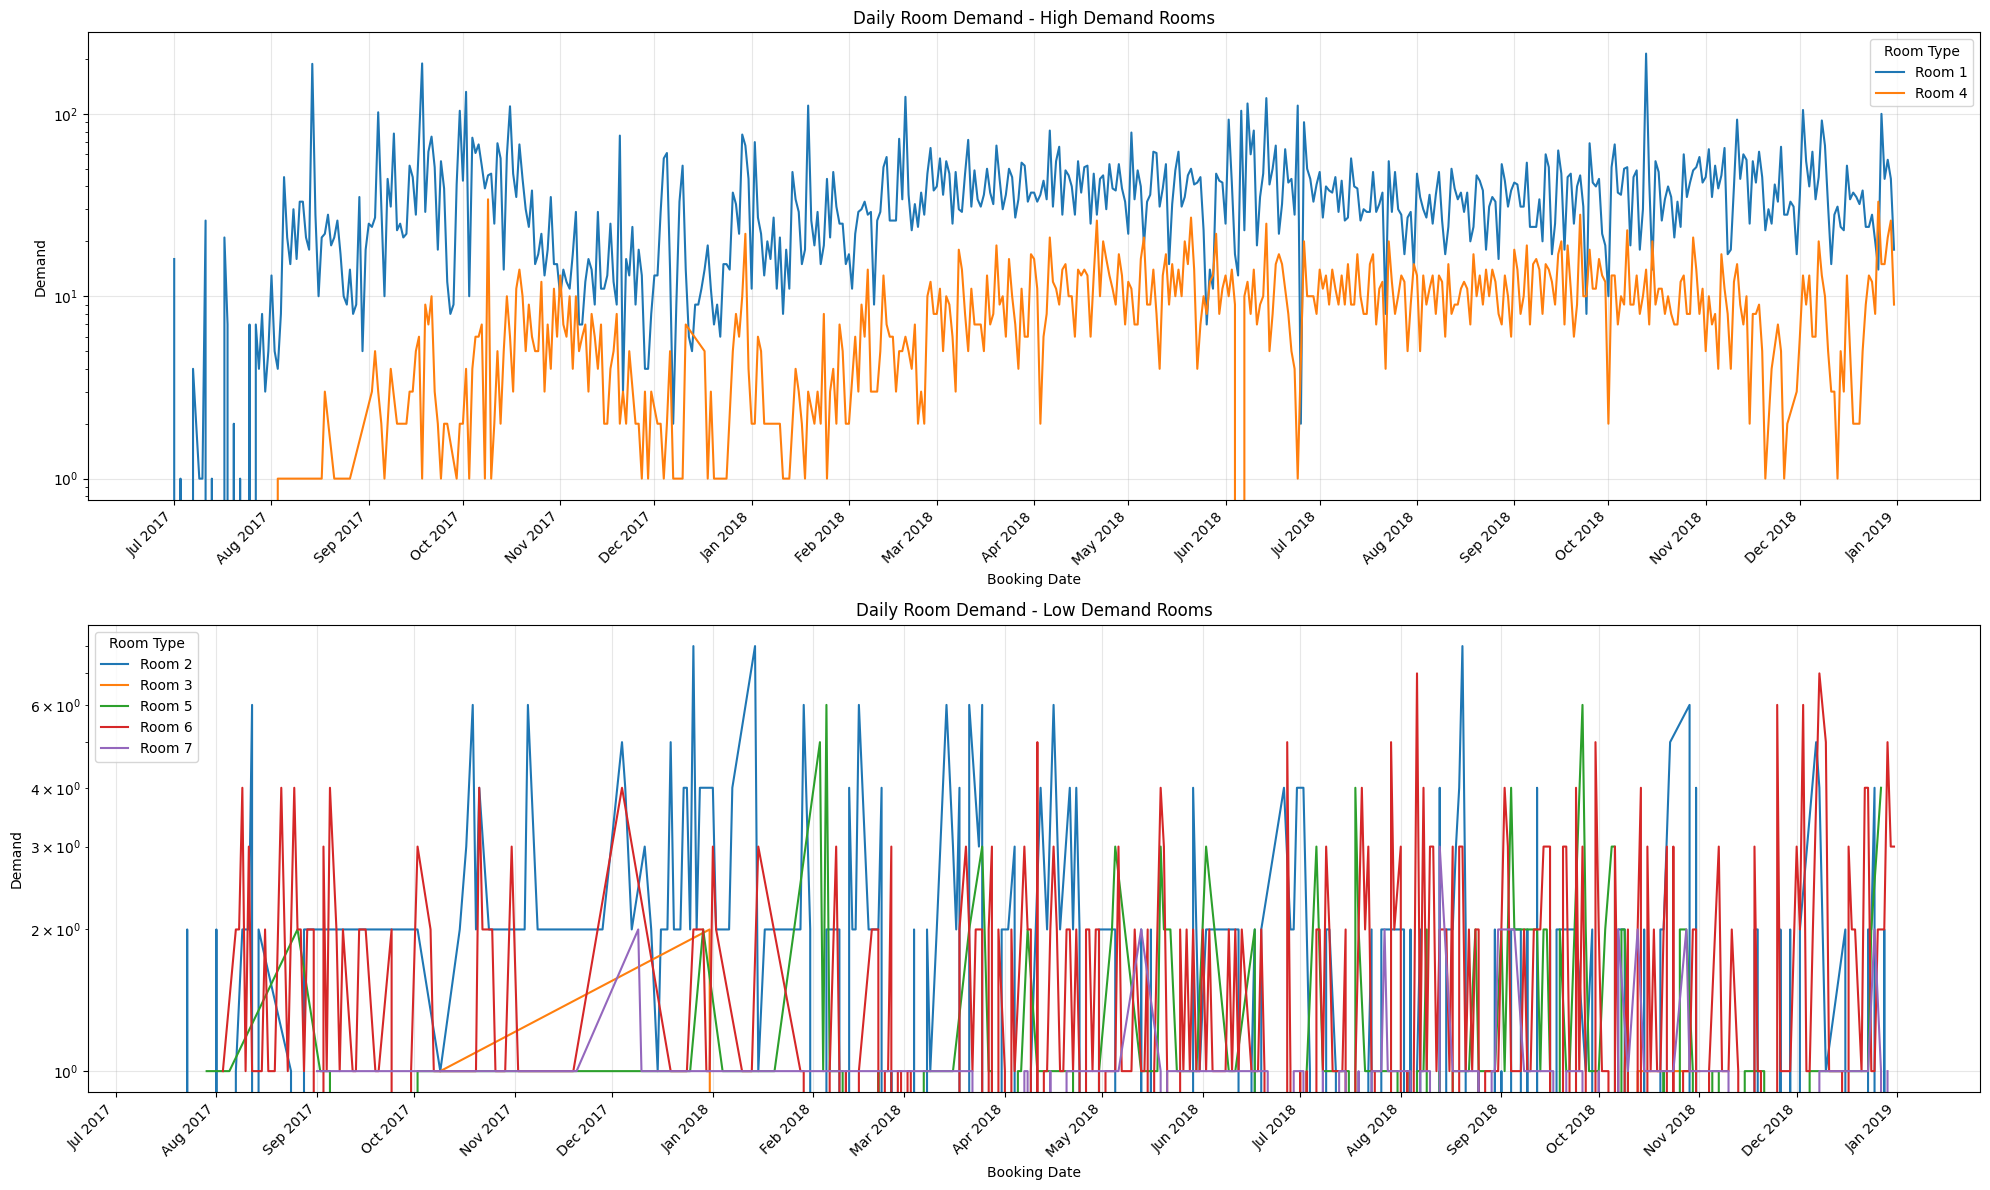

In [23]:
high_demand_rooms = [1, 4]
low_demand_rooms = [2, 3, 5, 6, 7]

plt.figure(figsize = (20, 12))

for i, (rooms, title) in enumerate([(high_demand_rooms, 'High Demand Rooms'), 
                                  (low_demand_rooms, 'Low Demand Rooms')], 1):
   plt.subplot(2, 1, i)
   
   for room_type in rooms:
       df_subset = daily_room_demand_df[daily_room_demand_df['room_type'] == room_type]
       plt.plot(df_subset['booking_date'], df_subset['demand'], label = f'Room {room_type}')
       
       plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
       plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
   
   plt.xlabel('Booking Date')
   plt.ylabel('Demand')
   plt.yscale('log')
   plt.title(f'Daily Room Demand - {title}')
   plt.legend(title = 'Room Type')
   plt.xticks(rotation = 45, ha = 'right')
   plt.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

**Observation**   

Room types ***1 and 4*** are the most demanded and follow a relatively similar depand trend with similar highs and lows.   

Room types ***2, 3, 5, 6, and 7*** on the other hand are a little less in demand and more sporandic in nature when compared to the demand of `1 and 4`... They may be more dominant with a specific user segment or last minute buyers, however, the goal of this project is to optimise pricing for the most in demand rooms, and I will focus on that.

## Analysis of Variance (ANOVA) & Correlation

In [24]:
# just aggregating all features per daily basis.

daily_features = df_clean[df_clean['status'] == 1].groupby(['booking_date', 'room_type']).agg({
    'n_adults':'mean',   'n_children':'mean',   'weekend_nights': 'mean',
    'week_nights':'mean',   'meal_plan':lambda x: x.mode()[0],
    'car_parking_space':'mean',   'lead_time':'mean',   
    'year': 'first',   'month':'first',   'date':'first',
    'previous_cancellations':'mean',   'previous_bookings_not_canceled':'mean',
    'avg_room_price':'mean',   'special_requests':'mean',
    'market_segment_Complementary':'mean', 'market_segment_Corporate':'mean',
    'market_segment_Offline':'mean', 'market_segment_Online':'mean'}).reset_index()

full_data = pd.merge(daily_demand_df, daily_features, on = 'booking_date')

In [25]:
# collecting all significant variables as and their p-values
sigificant_covariates = []

# ANOVA
categorical_cols = ['meal_plan', 'room_type', 'car_parking_space', 'year', 'month', 'date']

print('ANOVA results:')
for col in categorical_cols:
    groups = [group['demand'].values for _, group in full_data.groupby(col)]
    if len(groups) > 1:
        f_stat, p_val = stats.f_oneway(*groups)
        print(f'{col:35} F = {f_stat:.3f}, p = {p_val:.4f}')
        if p_val <= 0.05:
            sigificant_covariates.append(col)
    else:
        print(f'{col:35}: Skipped (only one group present)')


# Pearson correlation
numeric_cols = [
    'n_adults', 'n_children', 'weekend_nights', 'week_nights',
    'lead_time', 'previous_cancellations', 'previous_bookings_not_canceled',
    'avg_room_price', 'special_requests', 'market_segment_Complementary',
    'market_segment_Corporate', 'market_segment_Offline', 'market_segment_Online']

print('\nPearson correlation results:')
for col in numeric_cols:
    corr, p_val = stats.pearsonr(full_data[col], full_data['demand'])
    print(f"{col:35} r = {corr:.3f}, p = {p_val:.4f}")
    if p_val <= 0.05:
            sigificant_covariates.append(col)

print(f'\n\nAll significant variables with p-value <= 0.05:\n{sigificant_covariates}')

ANOVA results:
meal_plan                           F = 0.085, p = 0.9680
room_type                           F = 6.373, p = 0.0000
car_parking_space                   F = 1.816, p = 0.0000
year                                F = 120.880, p = 0.0000
month                               F = 18.711, p = 0.0000
date                                F = 3.099, p = 0.0000

Pearson correlation results:
n_adults                            r = 0.037, p = 0.1285
n_children                          r = 0.022, p = 0.3711
weekend_nights                      r = -0.075, p = 0.0019
week_nights                         r = 0.010, p = 0.6869
lead_time                           r = 0.117, p = 0.0000
previous_cancellations              r = -0.064, p = 0.0080
previous_bookings_not_canceled      r = -0.022, p = 0.3655
avg_room_price                      r = 0.197, p = 0.0000
special_requests                    r = 0.043, p = 0.0726
market_segment_Complementary        r = -0.058, p = 0.0166
market_segment_Corpo

**Observation**   

Well... ***meal plan, number of visitors (adults and kids), number of week nights*** and a few other factors seem not to have relavant impact on the demand. On the flip side, something quite interesting pops up. of all the market segments, only the complementary segment seems to affect demand.   

Next, I will estimate the baseline elasticity of demand, then begin incorporating the statistically significant variables to assess their effect on elasticity estimation.

# Price Elasticity of Demand Modelling

## Room Type 1 - Linear & Quadratic Estimates

In [26]:
room_type_1_df = full_data[full_data['room_type'] == 1]
room_type_4_df = full_data[full_data['room_type'] == 4]

In [27]:
df = room_type_1_df.copy()
df['log_price'] = np.log(df['avg_room_price'])
df['log_demand'] = np.log(df['demand'])

df = df.sort_values('log_price')

# linear OLS
X_linear = sm.add_constant(df['log_price'])
model_linear = sm.OLS(df['log_demand'], X_linear).fit()
df['pred_linear'] = model_linear.predict(X_linear)

# Quadratic OLS - log-price
df['log_price_squared'] = df['log_price'] ** 2
X_poly = sm.add_constant(df[['log_price', 'log_price_squared']])
model_poly = sm.OLS(df['log_demand'], X_poly).fit()
df['pred_poly'] = model_poly.predict(X_poly)

In [28]:
print(model_linear.summary())
print(f'\n{"#" * 90}\n')
print(f'\n{"#" * 90}\n')
print(model_poly.summary())

                            OLS Regression Results                            
Dep. Variable:             log_demand   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     99.83
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           1.15e-21
Time:                        21:49:18   Log-Likelihood:                -576.68
No. Observations:                 536   AIC:                             1157.
Df Residuals:                     534   BIC:                             1166.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4617      0.807     -5.529      0.0

**Observation**   

The polynomial (quadratic) model fits the data better, and its term `-6.1634`, together with the linear term suggests that the ***relationship between price and demand is non-linear*** and of an `inverted U-shape`, meaning that prices are elastic however, ****after a certain price point, they become less and less attractive to customers**** for ***room type 1***. I expect somewhat similar pattern with ***room type 4*** since their daily demand line plots looked similar.   

**Next**, I will visualise the observed log-price/log-demand and the estimated OLS best fit lines for better visual interpretation.

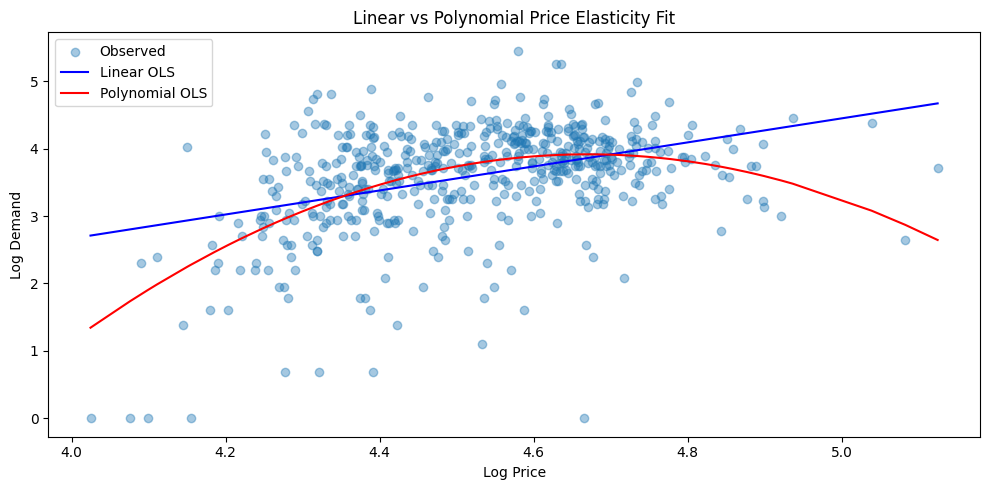

In [29]:
plt.figure(figsize = (10, 5))
plt.scatter(df['log_price'], df['log_demand'], alpha = 0.4, label = 'Observed')
plt.plot(df['log_price'], df['pred_linear'], label = 'Linear OLS', color = 'blue')
plt.plot(df['log_price'], df['pred_poly'], label = 'Polynomial OLS', color = 'red')

plt.xlabel('Log Price')
plt.ylabel('Log Demand')
plt.title('Linear vs Polynomial Price Elasticity Fit')
plt.legend()
plt.tight_layout();

In [30]:
beta_1 = model_poly.params['log_price']
beta_2 = model_poly.params['log_price_squared']

turning_point_log_price = -beta_1 / (2 * beta_2)
turning_point_price = np.exp(turning_point_log_price)

print(f'According to the polynomial model, demand for "Room Type 1" increases as price goes up, till the price hits *{round(turning_point_price, 2)}*, \
at which point it stops being attractive to customers.')

According to the polynomial model, demand for "Room Type 1" increases as price goes up, till the price hits *106.75*, at which point it stops being attractive to customers.


In [31]:
elasticities = model_poly.params['log_price'] + 2 * model_poly.params['log_price_squared'] * df['log_price']
overall_elasticity = elasticities.mean()
print(f'Overall average elasticity across "Room Type 1": {overall_elasticity:.3f}')

Overall average elasticity across "Room Type 1": 1.839


**Observation**   

The data relationship is definately non-linear and the polynomial model shows that clearly in the plot above.

## Room Type 4 - Linear & Quadratic Estimates

In [32]:
df = room_type_4_df.copy()
df['log_price'] = np.log(df['avg_room_price'])
df['log_demand'] = np.log(df['demand'])

df = df.sort_values('log_price')

# linear OLS
X_linear = sm.add_constant(df['log_price'])
model_linear = sm.OLS(df['log_demand'], X_linear).fit()
df['pred_linear'] = model_linear.predict(X_linear)

# Quadratic OLS - log-price
df['log_price_squared'] = df['log_price'] ** 2
X_poly = sm.add_constant(df[['log_price', 'log_price_squared']])
model_poly = sm.OLS(df['log_demand'], X_poly).fit()
df['pred_poly'] = model_poly.predict(X_poly)

In [33]:
print(model_linear.summary())
print(f'\n{"#" * 90}\n')
print(f'\n{"#" * 90}\n')
print(model_poly.summary())

                            OLS Regression Results                            
Dep. Variable:             log_demand   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     108.9
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.65e-23
Time:                        21:49:19   Log-Likelihood:                -341.61
No. Observations:                 469   AIC:                             687.2
Df Residuals:                     467   BIC:                             695.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8269      0.439     -1.883      0.0

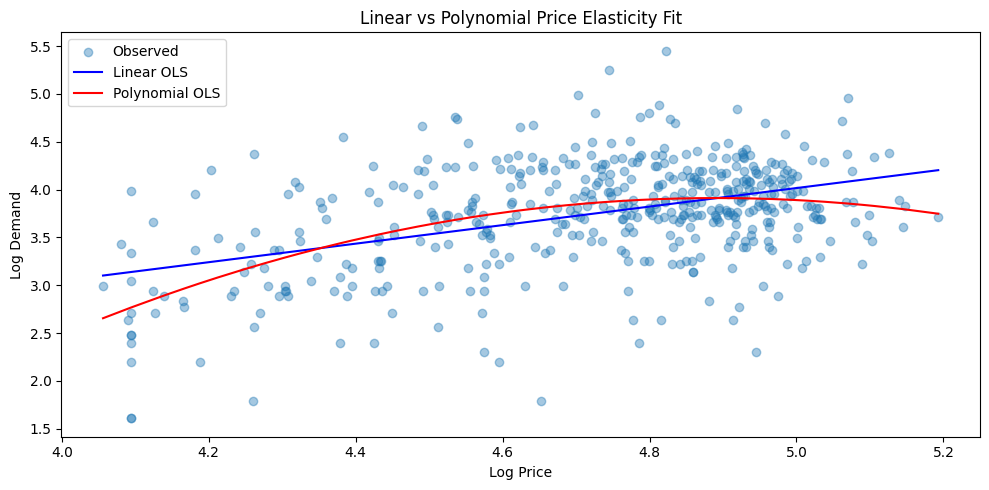

In [34]:
plt.figure(figsize = (10, 5))
plt.scatter(df['log_price'], df['log_demand'], alpha = 0.4, label = 'Observed')
plt.plot(df['log_price'], df['pred_linear'], label = 'Linear OLS', color = 'blue')
plt.plot(df['log_price'], df['pred_poly'], label = 'Polynomial OLS', color = 'red')

plt.xlabel('Log Price')
plt.ylabel('Log Demand')
plt.title('Linear vs Polynomial Price Elasticity Fit')
plt.legend()
plt.tight_layout();

In [35]:
beta_1 = model_poly.params['log_price']
beta_2 = model_poly.params['log_price_squared']

turning_point_log_price = -beta_1 / (2 * beta_2)
turning_point_price = np.exp(turning_point_log_price)

print(f'According to the polynomial model, demand for "Room Type 4" increases as price goes up, till the price hits *{round(turning_point_price, 2)}*, \
at which point it stops being attractive to customers.')

According to the polynomial model, demand for "Room Type 4" increases as price goes up, till the price hits *133.14*, at which point it stops being attractive to customers.


In [36]:
elasticities = model_poly.params['log_price'] + 2 * model_poly.params['log_price_squared'] * df['log_price']
overall_elasticity = elasticities.mean()
print(f'Overall average elasticity across "Room Type 4": {overall_elasticity:.3f}')

Overall average elasticity across "Room Type 4": 0.603


**Observation**   

As expected, slightly similar interved U-shape pattern, with the polynomial version performing better as shown by it higher higher R-squared, and lower AIC/BIC.   

**Note** that I conducted a few other now deleted experiments, addiing the other variables as regressors/dummy variables, and the results weren't noteworthy.... For simplicity and explainability sake, I will be sticking with the polynomial OLS.

# Prophet - Demand Estimation & Price Optimisation

## Room Type 1

## Room Type 4